In [ ]:
import os

# إنشاء مجلد لإعداد Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # تأمين الملف

print("✅ تم إعداد Kaggle API بنجاح!")


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
✅ تم إعداد Kaggle API بنجاح!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

data_root = "/content/drive/MyDrive/KaggleData"

if os.path.exists(data_root):
    print("📂 الملفات والمجلدات داخل KaggleData:")
    print(os.listdir(data_root))
else:
    print("❌ لم يتم العثور على مجلد KaggleData! تأكد من أنه لا يزال موجودًا في Google Drive.")


📂 الملفات والمجلدات داخل KaggleData:
['lung_colon_image_set']


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')  # ربط Google Drive

# # تحميل البيانات من Kaggle إلى Google Drive
# !kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images -p "/content/drive/MyDrive/KaggleData" --unzip

# print("✅ تم تحميل البيانات بنجاح إلى Google Drive!")


data_path = "/content/drive/MyDrive/KaggleData/lung_colon_image_set/lung_image_sets"
print("✅ تم استرجاع البيانات من Google Drive:", os.listdir(data_path))


✅ تم استرجاع البيانات من Google Drive: ['lung_aca', 'lung_n', 'lung_scc']


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import cv2
import matplotlib.pyplot as plt
import random
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import models, layers
import keras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.applications import VGG16,EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout

In [ ]:
data_path =  "/content/drive/MyDrive/KaggleData/lung_colon_image_set/lung_image_sets"

In [ ]:
classes = sorted([d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))])

print("Dataset Classes:")
for cls in classes:
    print(cls)

Dataset Classes:
lung_aca
lung_n
lung_scc


In [ ]:
def create_dataframe(data_path):
    filepaths = []
    labels = []

    for fold in os.listdir(data_path):
        f_path = os.path.join(data_path, fold)
        if os.path.isdir(f_path):
            imgs = os.listdir(f_path)
            for img in imgs:
                img_path = os.path.join(f_path, img)
                filepaths.append(img_path)
                labels.append(fold)

    fseries = pd.Series(filepaths, name='Filepaths')
    lseries = pd.Series(labels, name='Labels')
    return pd.concat([fseries, lseries], axis=1)

# Create DataFrame for the dataset
df = create_dataframe(data_path)

In [ ]:
df

Filepaths    Labels
0      /content/drive/MyDrive/KaggleData/lung_colon_i...  lung_aca
1      /content/drive/MyDrive/KaggleData/lung_colon_i...  lung_aca
2      /content/drive/MyDrive/KaggleData/lung_colon_i...  lung_aca
3      /content/drive/MyDrive/KaggleData/lung_colon_i...  lung_aca
4      /content/drive/MyDrive/KaggleData/lung_colon_i...  lung_aca
...                                                  ...       ...
14995  /content/drive/MyDrive/KaggleData/lung_colon_i...  lung_scc
14996  /content/drive/MyDrive/KaggleData/lung_colon_i...  lung_scc
14997  /content/drive/MyDrive/KaggleData/lung_colon_i...  lung_scc
14998  /content/drive/MyDrive/KaggleData/lung_colon_i...  lung_scc
14999  /content/drive/MyDrive/KaggleData/lung_colon_i...  lung_scc

[15000 rows x 2 columns]

In [ ]:
# Step 1: Split into 70% training and 30% dummy, stratifying by labels
train_df, dummy_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=42, stratify=df['Labels'])

# Step 2: Split dummy_df into 20% testing and 10% validation, stratifying by labels
test_df, valid_df = train_test_split(dummy_df, train_size=2/3, shuffle=True, random_state=42, stratify=dummy_df['Labels'])

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
# Validation and test data generators remain the same
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 10500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 3000 validated image filenames belonging to 3 classes.


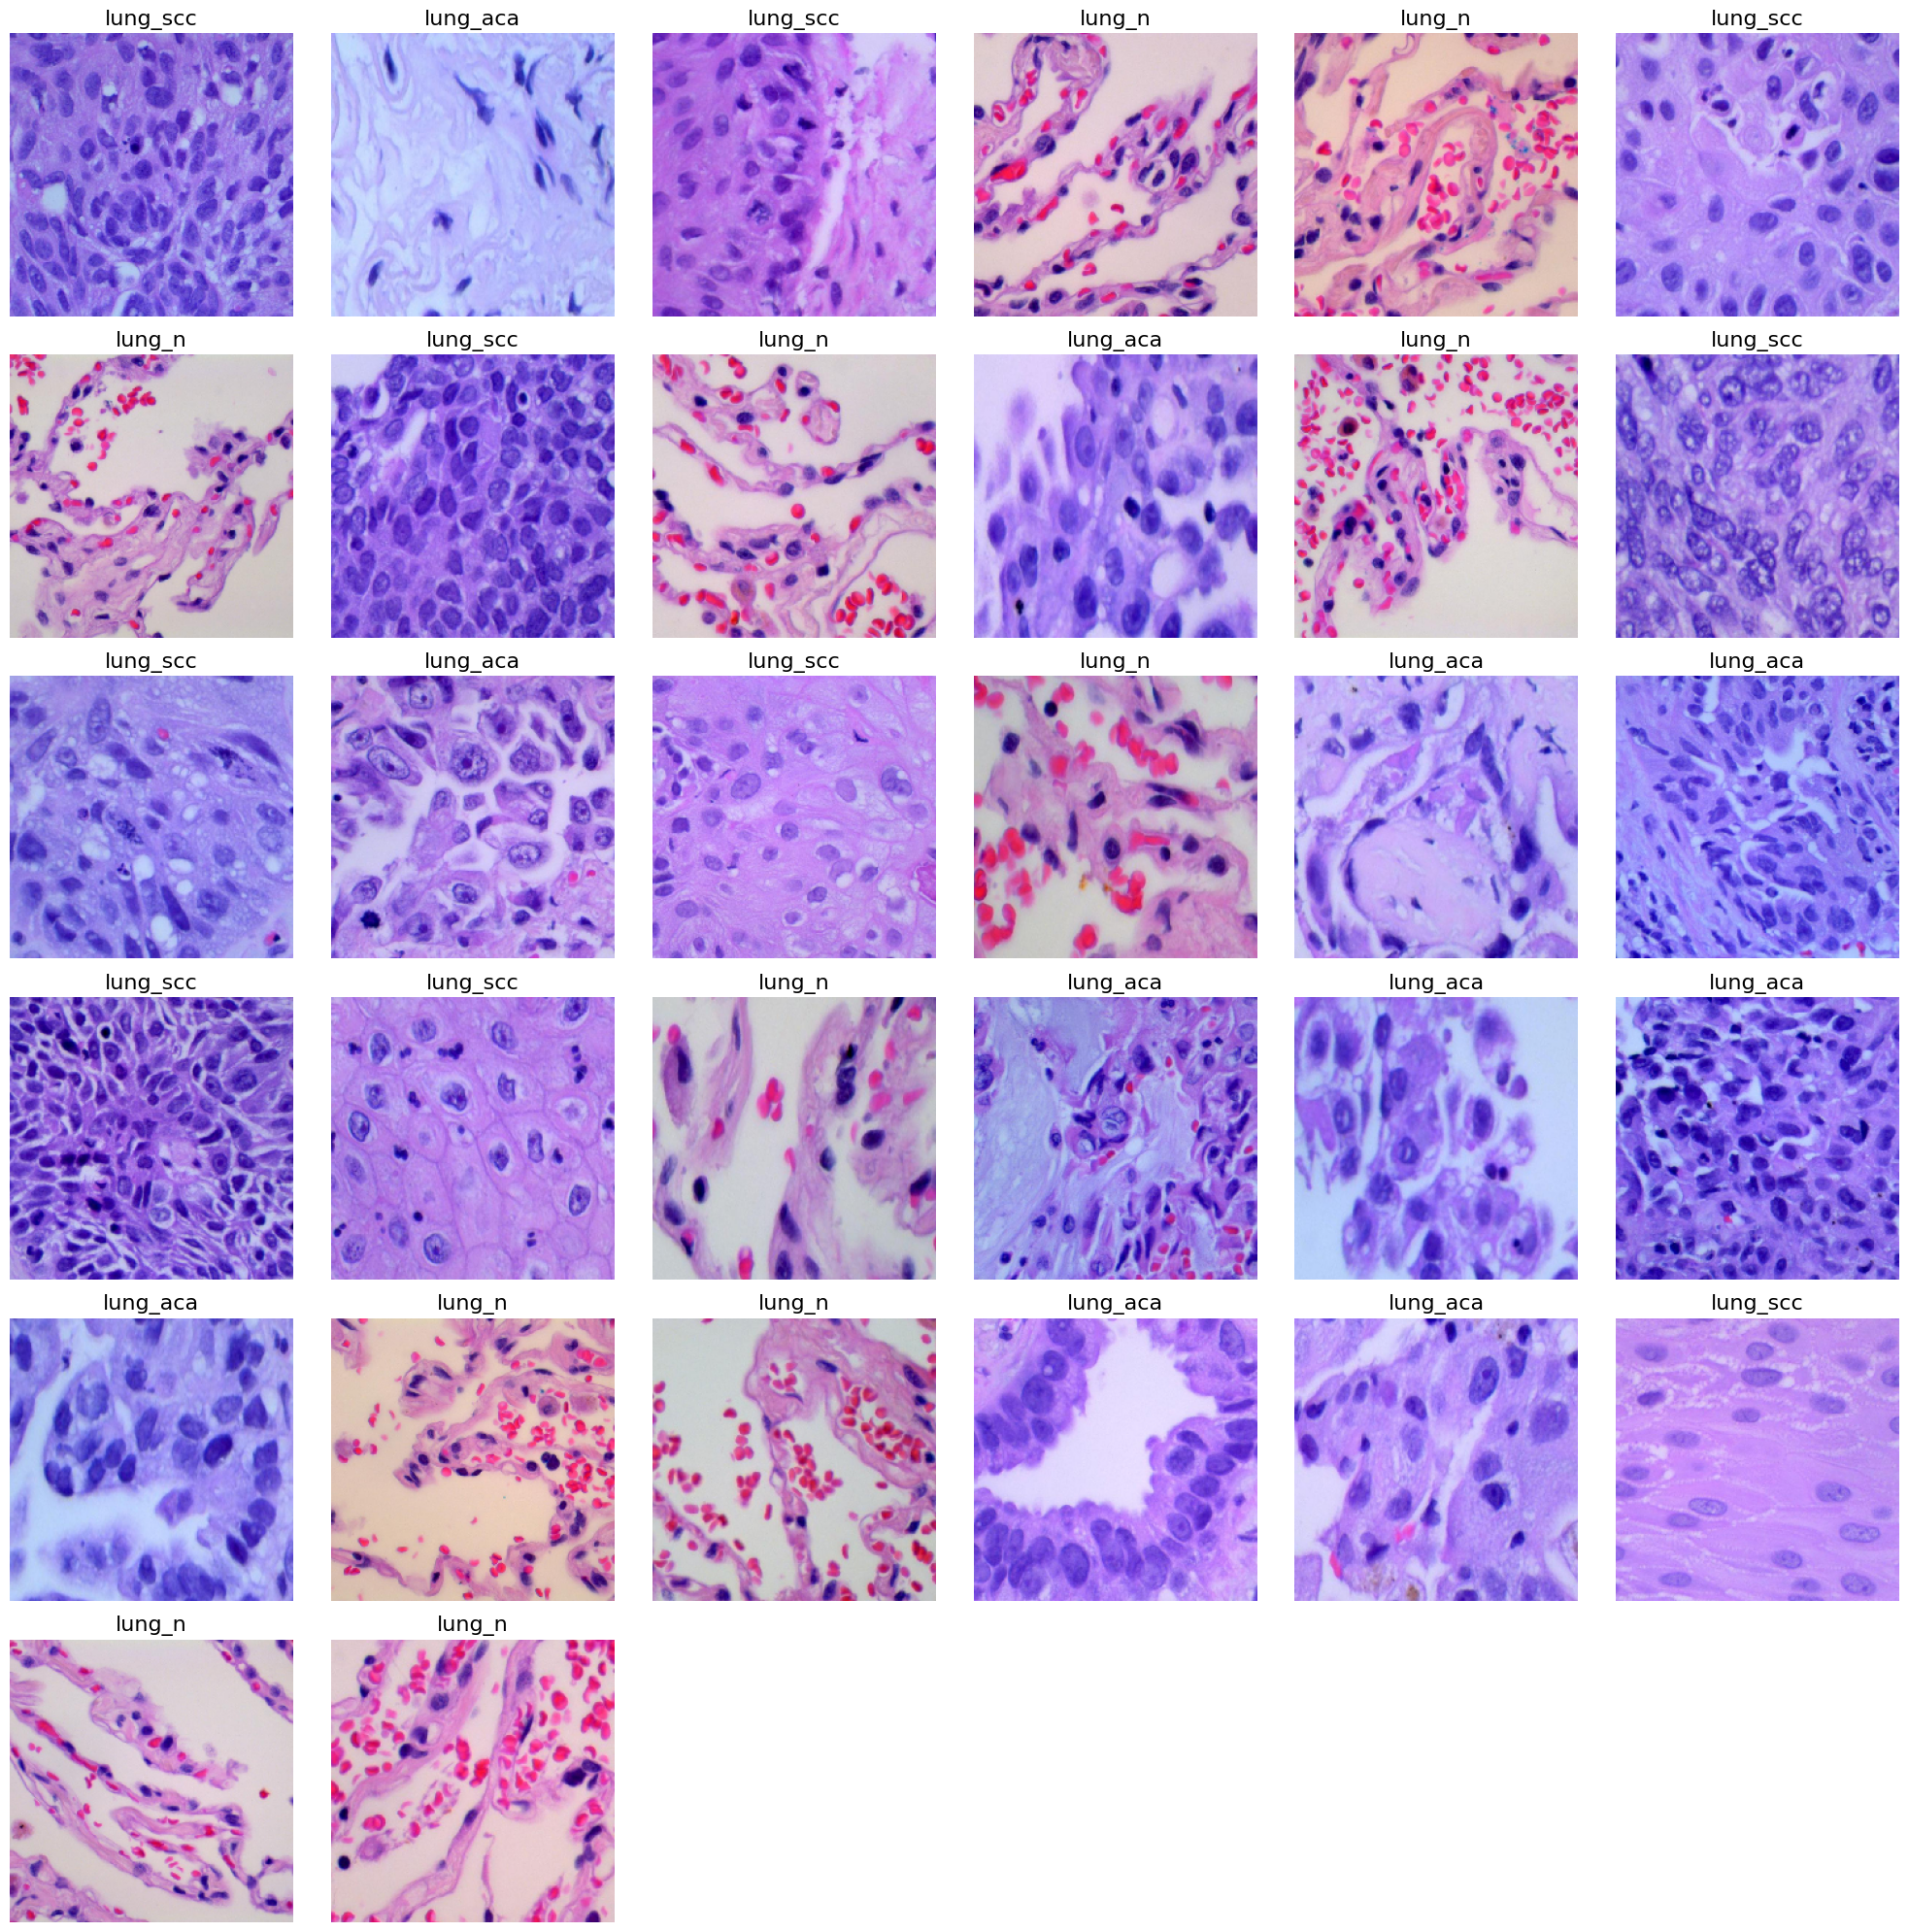

In [ ]:
g_dict = train_generator.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_generator)      # get a batch size samples from the generator

# ploting the patch size samples
plt.figure(figsize= (20, 20))

for i in range(32):
    plt.subplot(6, 6, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Displaying the model performance
def model_performance(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    Epochs = [i+1 for i in range(len(tr_acc))]

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


# Evaluate the model
def model_evaluation(model):
    train_score = model.evaluate(train_generator, verbose= 1)
    valid_score = model.evaluate(valid_generator, verbose= 1)
    test_score = model.evaluate(test_generator, verbose= 1)

    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])

# Confusion Matrix
import itertools

def plot_confusion_matrix(test_gen, y_pred):

    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())

    # Display the confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')


    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.show()



# Get Predictions
def get_pred(model, test_gen):

    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis = 1)

    return y_pred




In [ ]:
# Load the VGG16 model, excluding the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base to retain the pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for our specific classification task
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)

# Combine base model and custom layers
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Train the model and store training details in history
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15,
    batch_size=32
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 3859s 12s/step - accuracy: 0.8780 - loss: 0.3036 - val_accuracy: 0.9553 - val_loss: 0.1039
Epoch 2/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 97s 295ms/step - accuracy: 0.9592 - loss: 0.1012 - val_accuracy: 0.9600 - val_loss: 0.0986
Epoch 3/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 85s 259ms/step - accuracy: 0.9689 - loss: 0.0813 - val_accuracy: 0.9713 - val_loss: 0.0692
Epoch 4/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 83s 252ms/step - accuracy: 0.9770 - loss: 0.0588 - val_accuracy: 0.9787 - val_loss: 0.0597
Epoch 5/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 95s 290ms/step - accuracy: 0.9831 - loss: 0.0488 - val_accuracy: 0.9813 - val_loss: 0.0578
Epoch 6/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 87s 265ms/step - accuracy: 0.9889 - loss: 0.0385 - val_accuracy: 0.9840 - val_loss: 0.0489
Epoch 7/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 97s 294ms/step - accuracy: 0.9880 - loss: 0.0327 - val_accuracy: 0.9813 - val_loss: 0.0527
Epoch 8/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 85s 258ms/step - accuracy: 0.9915 - loss: 0

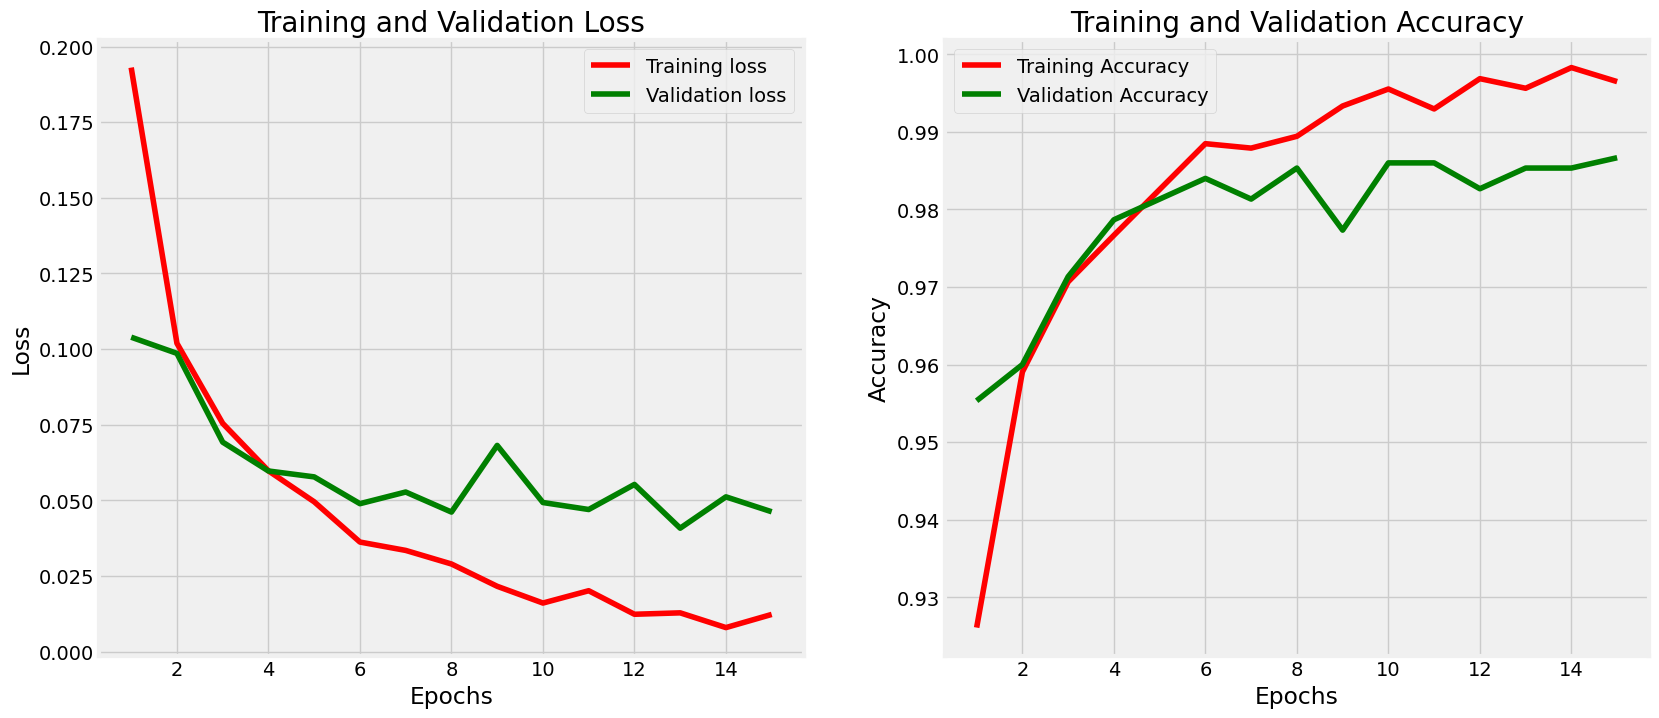

In [ ]:
# Display model performance
model_performance(history, 15)

In [ ]:
# Model evaluation
model_evaluation(model)

329/329 ━━━━━━━━━━━━━━━━━━━━ 82s 250ms/step - accuracy: 0.9999 - loss: 0.0035
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 221ms/step - accuracy: 0.9851 - loss: 0.0438


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 969s 10s/step - accuracy: 0.9848 - loss: 0.0404
Train Loss:  0.0033995637204498053
Train Accuracy:  0.9998095035552979
--------------------
Validation Loss:  0.0462167002260685
Validation Accuracy:  0.9866666793823242
--------------------
Test Loss:  0.043123699724674225
Test Accuracy:  0.9853333234786987


94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 234ms/step


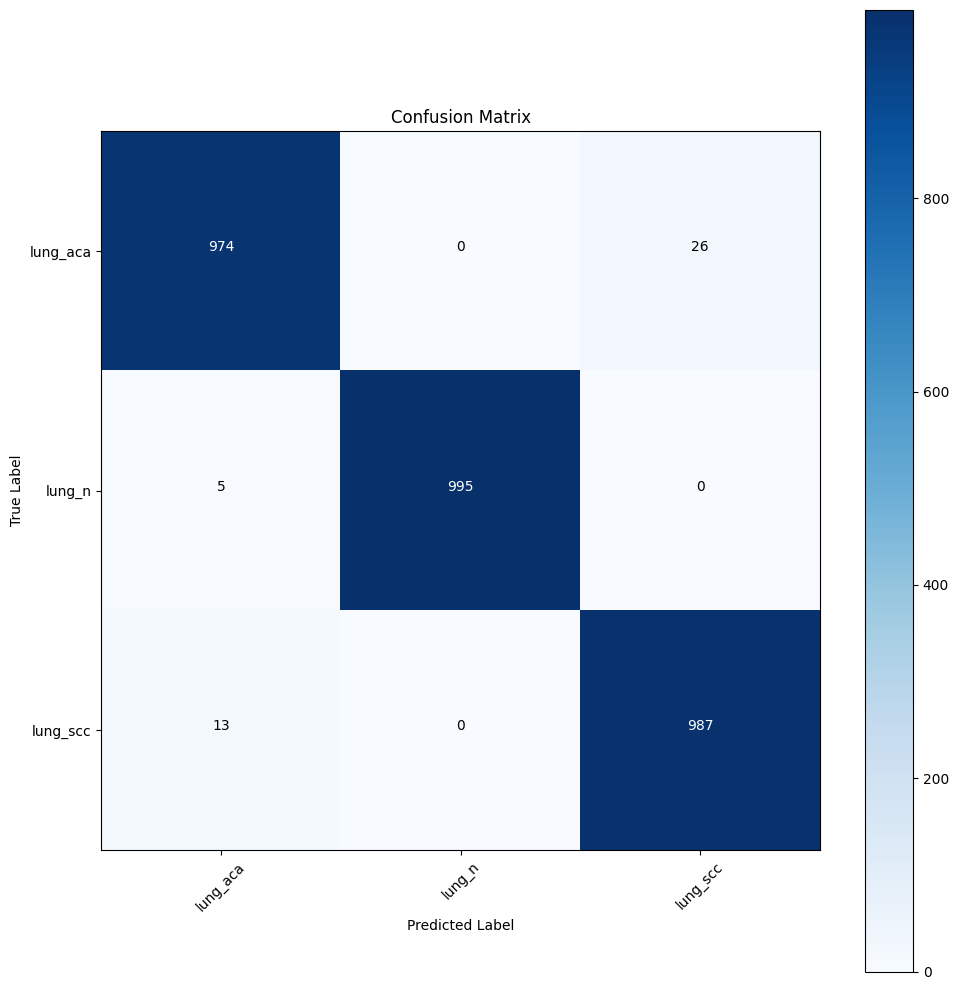

In [ ]:
# get predictions
y_pred = get_pred(model, test_generator)

# plot the confusion matrix
plot_confusion_matrix(test_generator, y_pred)

In [ ]:
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 229ms/step
              precision    recall  f1-score   support

    lung_aca       0.98      0.97      0.98      1000
      lung_n       1.00      0.99      1.00      1000
    lung_scc       0.97      0.99      0.98      1000

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



In [ ]:
def predict(model, img, class_names):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

class_names = list(test_generator.class_indices.keys())

images_batch, labels_batch = next(test_generator)
for i in range(min(len(images_batch), 9)):
    predicted_class, confidence = predict(model, images_batch[i], class_names)
    actual_class = class_names[np.argmax(labels_batch[i])]

    print(f"Actual: {actual_class}, Predicted: {predicted_class}, Confidence: {confidence}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Actual: lung_scc, Predicted: lung_scc, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Actual: lung_aca, Predicted: lung_aca, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Actual: lung_n, Predicted: lung_n, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Actual: lung_n, Predicted: lung_n, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Actual: lung_n, Predicted: lung_n, Confidence: 99.98%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Actual: lung_scc, Predicted: lung_scc, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Actual: lung_aca, Predicted: lung_aca, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Actual: lung_scc, Predicted: lung_scc, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Actual: lung_scc, Predicted: lung_scc, Confidence: 99.89%


#EfficientNetB3


In [ ]:
#  Defining a dense NN block for a sequential CNN model
def dense_block(units, dropout_rate, act='relu'):

    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))

    return block

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_counts = len(list(train_generator.class_indices.keys()))     # to define number of classes in dense layer

In [ ]:
# get the pre-trained model (EfficientNetB3)
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape = img_shape, pooling= None)

# fine-tune EfficientNetB3 (Adding some custom layers on top)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = dense_block(128, 0.5)(x)
x = dense_block(32, 0.2)(x)
predictions = Dense(class_counts, activation = "softmax")(x)    # output layer with softmax activation

# the model
EfficientNetB3_model = Model(inputs = base_model.input, outputs = predictions)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
EfficientNetB3_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

EfficientNetB3_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 40)   │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 40)   │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 40)   │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 40)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 10,991,282 (41.93 MB)

 Trainable params: 10,900,587 (41.58 MB)

 Non-trainable params: 90,695 (354.28 KB)

In [ ]:
epochs = 15  # number of all epochs in training
batch_size = 32

from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)



EfficientNetB3_history = EfficientNetB3_model.fit(train_generator, epochs= epochs,batch_size= batch_size, verbose= 1, validation_data= valid_generator, shuffle= False,callbacks=[early_stopping])

Epoch 1/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 99s 299ms/step - accuracy: 0.9965 - loss: 0.0188 - val_accuracy: 0.9980 - val_loss: 0.0070
Epoch 2/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 96s 291ms/step - accuracy: 0.9974 - loss: 0.0157 - val_accuracy: 0.9900 - val_loss: 0.0335
Epoch 3/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 96s 291ms/step - accuracy: 0.9971 - loss: 0.0159 - val_accuracy: 0.9833 - val_loss: 0.0484
Epoch 4/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 97s 294ms/step - accuracy: 0.9981 - loss: 0.0136 - val_accuracy: 0.9987 - val_loss: 0.0060
Epoch 5/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 97s 293ms/step - accuracy: 0.9961 - loss: 0.0166 - val_accuracy: 0.9993 - val_loss: 0.0046
Epoch 6/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 96s 290ms/step - accuracy: 0.9960 - loss: 0.0168 - val_accuracy: 0.9987 - val_loss: 0.0043
Epoch 7/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 97s 294ms/step - accuracy: 0.9956 - loss: 0.0202 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 8/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 96s 290ms/step - accuracy: 0.9980 - loss: 0

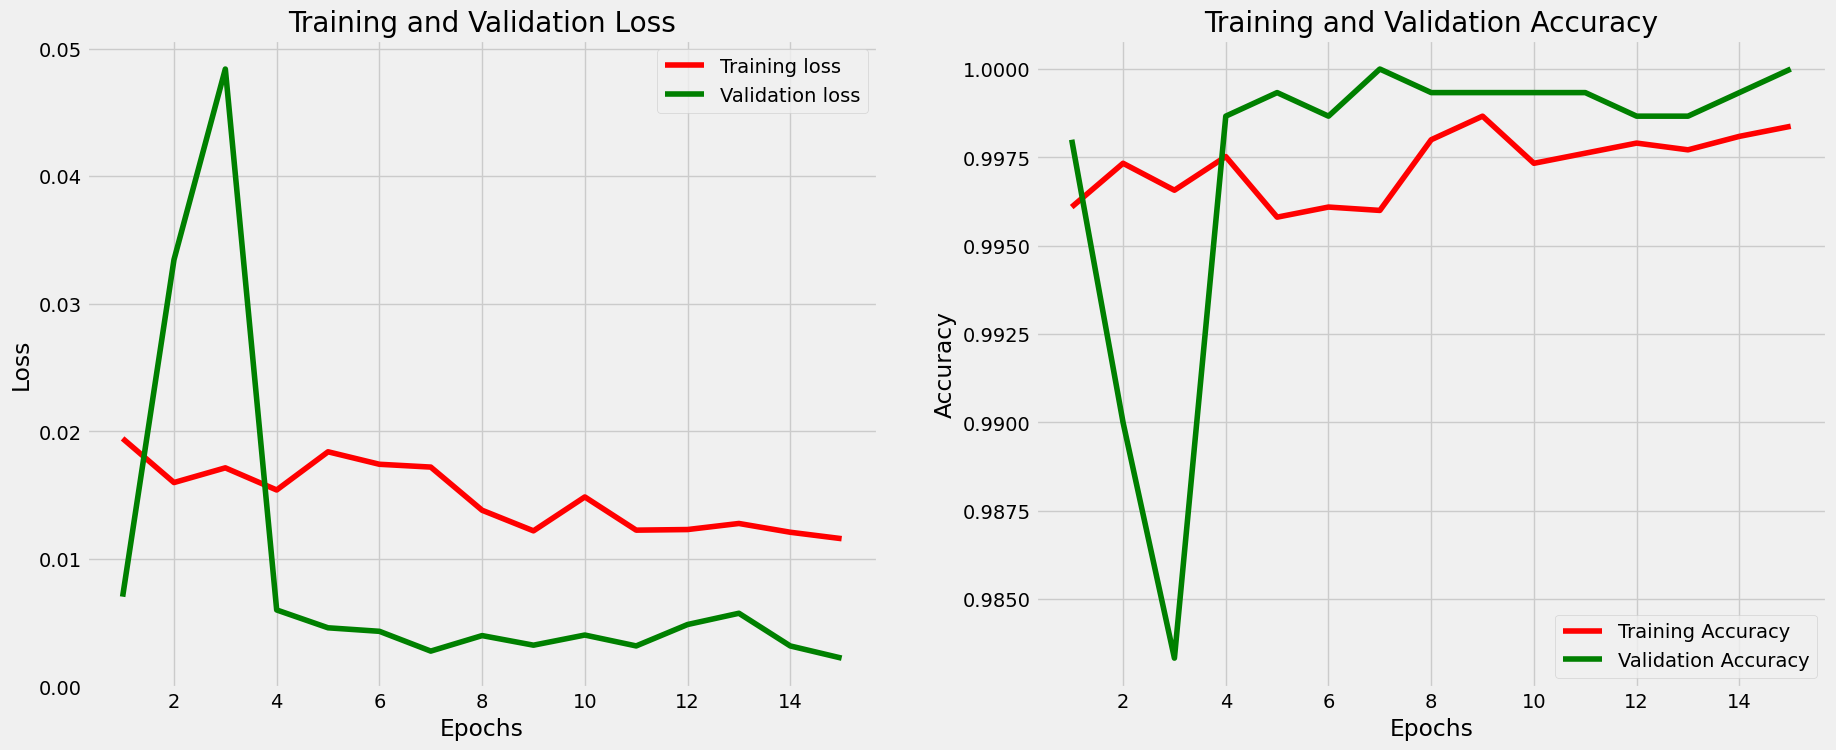

In [ ]:
# Display model performance
model_performance(EfficientNetB3_history, epochs)

In [ ]:
# Model evaluation
model_evaluation(EfficientNetB3_model)

329/329 ━━━━━━━━━━━━━━━━━━━━ 75s 228ms/step - accuracy: 1.0000 - loss: 9.0837e-04
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 215ms/step - accuracy: 1.0000 - loss: 0.0024
94/94 ━━━━━━━━━━━━━━━━━━━━ 24s 258ms/step - accuracy: 0.9996 - loss: 0.0035
Train Loss:  0.0009155223378911614
Train Accuracy:  1.0
--------------------
Validation Loss:  0.0022289950866252184
Validation Accuracy:  1.0
--------------------
Test Loss:  0.003638589521870017
Test Accuracy:  0.9993333220481873


In [ ]:
# Confusion Matrix
import itertools

def plot_confusion_matrix(test_gen, y_pred):

    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())

    # Display the confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')


    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 325ms/step


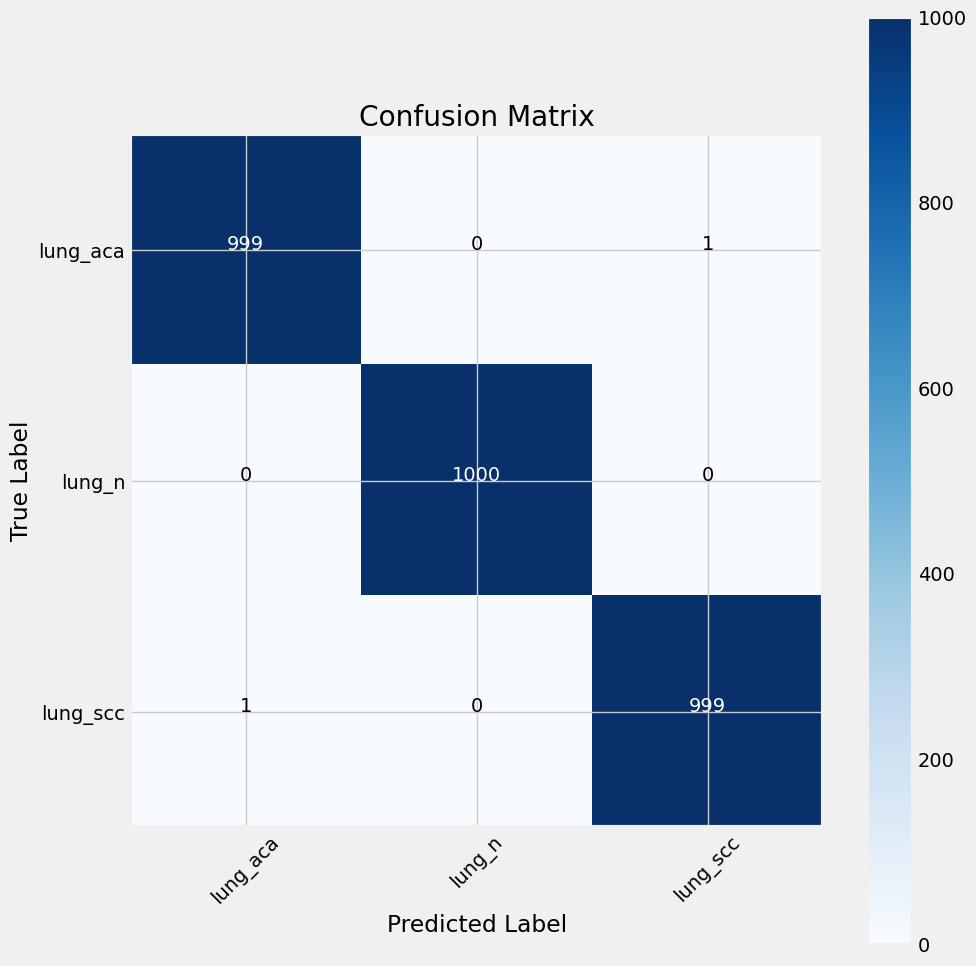

In [ ]:
# get predictions
y_pred = get_pred(EfficientNetB3_model, test_generator)

# plot the confusion matrix
plot_confusion_matrix(test_generator, y_pred)

In [ ]:
model.save("/content/drive/MyDrive/your_model.h5")

In [ ]:
model.save("/content/drive/MyDrive/your_model.keras")

In [ ]:
EfficientNetB3_model.save("/content/drive/MyDrive/your_model.keras")

In [ ]:
EfficientNetB3_model.save("/content/drive/MyDrive/your_model.h5")

transfair model


In [ ]:
import tensorflow as tf

# تحويل النموذج إلى TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(EfficientNetB3_model)
tflite_model = converter.convert()


with open("/content/drive/MyDrive/your_model.tflite", "wb") as f:
    f.write(tflite_model)

print("تم تحويل النموذج إلى TFLite بنجاح!")


Saved artifact at '/tmp/tmphe1frbmm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140150919299152: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140150919314896: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140150941615120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140150941615696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140150941616656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140150941615888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140150941614160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140150941617616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140150941617232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140150941618576: TensorSpec(shape=(), dtype=tf.resource, name=Non

In [ ]:

tflite_model_path = "/content/drive/MyDrive/your_model.tflite"


import os
if os.path.exists(tflite_model_path):
    print("Model saved successfully.")
else:
    print("Model not found.")


Model saved successfully.
